# Anomaly Detection

En este ejemplo se usa la famosa base de datos [MNIST](https://en.wikipedia.org/wiki/MNIST_database) que tiene en letra manuscrita los 10 dígitos (0,1,...9). Se entrena el modelo para que el '0' sea la clase "normal", y todo el resto de dígitos sea considerado como "anomalía".

Implementacion basada en [f-AnoGan](http://github.com/dbbbbm/f-AnoGAN-PyTorch)

Esta umplementación ocupa como entrada imágenes de 3 canales de color de 64x64 pixeles. En caso de querer usar otras imágenes cambiar la función one_class_dataloader en F-AnoGan. En caso de querer usar otra dimensión de imágenes debería funcionar cambiando DIM y OUTpUT_DIM en WGAN 64x64.

Adaptación hecha por Joaquín Hofmann y Domingo Mery

Referencia:
Schlegl, T., Seeböck, P., Waldstein, S. M., Langs, G., & Schmidt-Erfurth, U. (2019). [f-AnoGAN: Fast unsupervised anomaly detection with generative adversarial networks](https://www.sciencedirect.com/science/article/abs/pii/S1361841518302640). Medical image analysis, 54, 30-44.

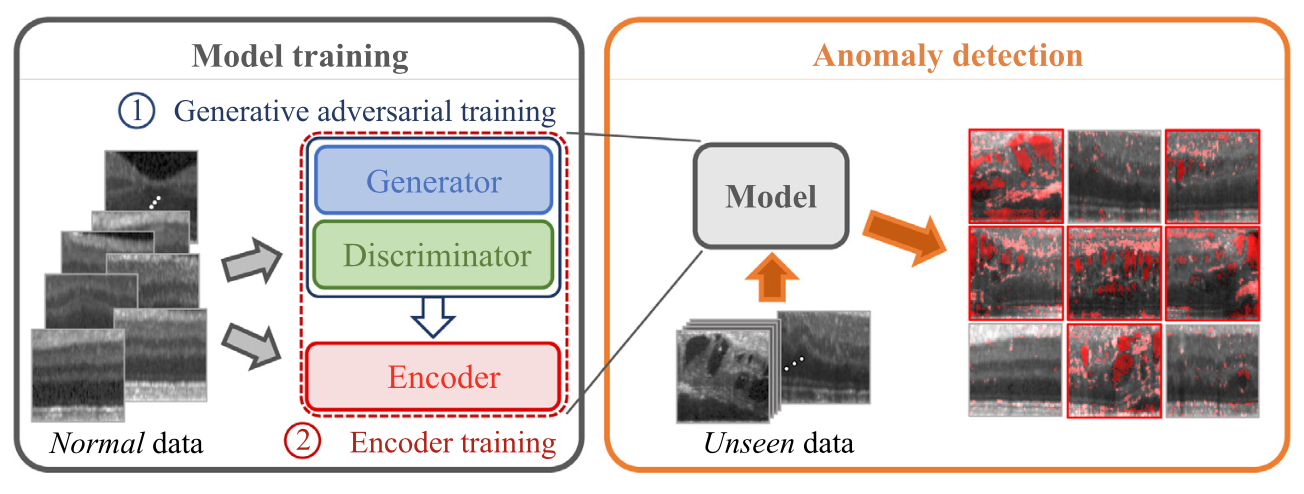

# Some functions

In [1]:
def num2fixstr(x,d):
  # example num2fixstr(2,5) returns '00002'
  # example num2fixstr(19,3) returns '019'
  st = '%0*d' % (d,x)
  return st

# WGAN 64x64

In [2]:
# wgan64x64.py
from torch import nn
from torch.autograd import grad
import torch
DIM = 64
OUTPUT_DIM = 3*64*64


class MyConvo2d(nn.Module):
    def __init__(self, input_dim, output_dim, kernel_size, he_init=True,  stride=1, bias=True):
        super(MyConvo2d, self).__init__()
        self.he_init = he_init
        self.padding = int((kernel_size - 1)/2)
        self.conv = nn.Conv2d(input_dim, output_dim, kernel_size,
                              stride=1, padding=self.padding, bias=bias)

    def forward(self, input):
        output = self.conv(input)
        return output


class ConvMeanPool(nn.Module):
    def __init__(self, input_dim, output_dim, kernel_size, he_init=True):
        super(ConvMeanPool, self).__init__()
        self.he_init = he_init
        self.conv = MyConvo2d(input_dim, output_dim,
                              kernel_size, he_init=self.he_init)

    def forward(self, input):
        output = self.conv(input)
        output = (output[:, :, ::2, ::2] + output[:, :, 1::2, ::2] +
                  output[:, :, ::2, 1::2] + output[:, :, 1::2, 1::2]) / 4
        return output


class MeanPoolConv(nn.Module):
    def __init__(self, input_dim, output_dim, kernel_size, he_init=True):
        super(MeanPoolConv, self).__init__()
        self.he_init = he_init
        self.conv = MyConvo2d(input_dim, output_dim,
                              kernel_size, he_init=self.he_init)

    def forward(self, input):
        output = input
        output = (output[:, :, ::2, ::2] + output[:, :, 1::2, ::2] +
                  output[:, :, ::2, 1::2] + output[:, :, 1::2, 1::2]) / 4
        output = self.conv(output)
        return output


class DepthToSpace(nn.Module):
    def __init__(self, block_size):
        super(DepthToSpace, self).__init__()
        self.block_size = block_size
        self.block_size_sq = block_size*block_size

    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, input_height, input_width, input_depth) = output.size()
        output_depth = int(input_depth / self.block_size_sq)
        output_width = int(input_width * self.block_size)
        output_height = int(input_height * self.block_size)
        t_1 = output.reshape(batch_size, input_height,
                             input_width, self.block_size_sq, output_depth)
        spl = t_1.split(self.block_size, 3)
        stacks = [t_t.reshape(batch_size, input_height,
                              output_width, output_depth) for t_t in spl]
        output = torch.stack(stacks, 0).transpose(0, 1).permute(0, 2, 1, 3, 4).reshape(
            batch_size, output_height, output_width, output_depth)
        output = output.permute(0, 3, 1, 2)
        return output


class UpSampleConv(nn.Module):
    def __init__(self, input_dim, output_dim, kernel_size, he_init=True, bias=True):
        super(UpSampleConv, self).__init__()
        self.he_init = he_init
        self.conv = MyConvo2d(input_dim, output_dim,
                              kernel_size, he_init=self.he_init, bias=bias)
        self.depth_to_space = DepthToSpace(2)

    def forward(self, input):
        output = input
        output = torch.cat((output, output, output, output), 1)
        output = self.depth_to_space(output)
        output = self.conv(output)
        return output


class ResidualBlock(nn.Module):
    def __init__(self, input_dim, output_dim, kernel_size, resample=None, hw=DIM):
        super(ResidualBlock, self).__init__()

        self.input_dim = input_dim
        self.output_dim = output_dim
        self.kernel_size = kernel_size
        self.resample = resample
        self.bn1 = None
        self.bn2 = None
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
        if resample == 'down':
            self.bn1 = nn.LayerNorm([input_dim, hw, hw])
            self.bn2 = nn.LayerNorm([input_dim, hw, hw])
        elif resample == 'up':
            self.bn1 = nn.BatchNorm2d(input_dim)
            self.bn2 = nn.BatchNorm2d(output_dim)
        elif resample == None:
            # TODO: ????
            self.bn1 = nn.BatchNorm2d(output_dim)
            self.bn2 = nn.LayerNorm([input_dim, hw, hw])
        else:
            raise Exception('invalid resample value')

        if resample == 'down':
            self.conv_shortcut = MeanPoolConv(
                input_dim, output_dim, kernel_size=1, he_init=False)
            self.conv_1 = MyConvo2d(
                input_dim, input_dim, kernel_size=kernel_size, bias=False)
            self.conv_2 = ConvMeanPool(
                input_dim, output_dim, kernel_size=kernel_size)
        elif resample == 'up':
            self.conv_shortcut = UpSampleConv(
                input_dim, output_dim, kernel_size=1, he_init=False)
            self.conv_1 = UpSampleConv(
                input_dim, output_dim, kernel_size=kernel_size, bias=False)
            self.conv_2 = MyConvo2d(
                output_dim, output_dim, kernel_size=kernel_size)
        elif resample == None:
            self.conv_shortcut = MyConvo2d(
                input_dim, output_dim, kernel_size=1, he_init=False)
            self.conv_1 = MyConvo2d(
                input_dim, input_dim, kernel_size=kernel_size, bias=False)
            self.conv_2 = MyConvo2d(
                input_dim, output_dim, kernel_size=kernel_size)
        else:
            raise Exception('invalid resample value')

    def forward(self, input):
        if self.input_dim == self.output_dim and self.resample == None:
            shortcut = input
        else:
            shortcut = self.conv_shortcut(input)

        output = input
        output = self.bn1(output)
        output = self.relu1(output)
        output = self.conv_1(output)
        output = self.bn2(output)
        output = self.relu2(output)
        output = self.conv_2(output)

        return shortcut + output


class ReLULayer(nn.Module):
    def __init__(self, n_in, n_out):
        super(ReLULayer, self).__init__()
        self.n_in = n_in
        self.n_out = n_out
        self.linear = nn.Linear(n_in, n_out)
        self.relu = nn.ReLU()

    def forward(self, input):
        output = self.linear(input)
        output = self.relu(output)
        return output


class FCGenerator(nn.Module):
    def __init__(self, FC_DIM=512):
        super(FCGenerator, self).__init__()
        self.relulayer1 = ReLULayer(128, FC_DIM)
        self.relulayer2 = ReLULayer(FC_DIM, FC_DIM)
        self.relulayer3 = ReLULayer(FC_DIM, FC_DIM)
        self.relulayer4 = ReLULayer(FC_DIM, FC_DIM)
        self.linear = nn.Linear(FC_DIM, OUTPUT_DIM)
        self.tanh = nn.Tanh()

    def forward(self, input):
        output = self.relulayer1(input)
        output = self.relulayer2(output)
        output = self.relulayer3(output)
        output = self.relulayer4(output)
        output = self.linear(output)
        output = self.tanh(output)
        return output


class GoodGenerator(nn.Module):
    def __init__(self, dim=DIM, output_dim=OUTPUT_DIM):
        super(GoodGenerator, self).__init__()

        self.dim = dim

        self.ln1 = nn.Linear(128, 4*4*8*self.dim)
        self.rb1 = ResidualBlock(8*self.dim, 8*self.dim, 3, resample='up')
        self.rb2 = ResidualBlock(8*self.dim, 4*self.dim, 3, resample='up')
        self.rb3 = ResidualBlock(4*self.dim, 2*self.dim, 3, resample='up')
        self.rb4 = ResidualBlock(2*self.dim, 1*self.dim, 3, resample='up')
        self.bn = nn.BatchNorm2d(self.dim)

        self.conv1 = MyConvo2d(1*self.dim, 3, 3)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        # print("PEROFORMING __init__")
        self.initialize()

    def initialize(self):
        # print("PEROFORMING INITIALIZATION")
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.LayerNorm):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward(self, input):
        # print("PEROFORMING forward")
        output = self.ln1(input.contiguous())
        output = output.view(-1, 8*self.dim, 4, 4)
        output = self.rb1(output)
        output = self.rb2(output)
        output = self.rb3(output)
        output = self.rb4(output)

        output = self.bn(output)
        output = self.relu(output)
        output = self.conv1(output)
        output = self.tanh(output)
        # output = output.view(-1, OUTPUT_DIM)
        return output




class GoodDiscriminator(nn.Module):
    def __init__(self, dim=DIM):
        super(GoodDiscriminator, self).__init__()

        self.dim = dim

        self.conv1 = MyConvo2d(3, self.dim, 3, he_init=False)
        self.rb1 = ResidualBlock(self.dim, 2*self.dim,
                                 3, resample='down', hw=DIM)
        self.rb2 = ResidualBlock(
            2*self.dim, 4*self.dim, 3, resample='down', hw=int(DIM/2))
        self.rb3 = ResidualBlock(
            4*self.dim, 8*self.dim, 3, resample='down', hw=int(DIM/4))
        self.rb4 = ResidualBlock(
            8*self.dim, 8*self.dim, 3, resample='down', hw=int(DIM/8))
        self.ln1 = nn.Linear(4*4*8*self.dim, 1)
        # print("PEROFORMING __init__")
        self.initialize()

    def initialize(self):
        # print("PEROFORMING INITIALIZATION")
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.LayerNorm):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)

    def extract_feature(self, input):
        output = input.contiguous()
        print("input.contigous() shape is: ", output.shape)
        output = output.view(-1, 3, DIM, DIM)
        print("new shape of output is: ", output.shape)
        output = self.conv1(output)
        print("after self.conv1, the shape of output is: ", output.shape)
        output = self.rb1(output)
        print("after self.rb1, the shape of output is: ", output.shape)
        output = self.rb2(output)
        print("after self.rb2, the shape of output is: ", output.shape)
        output = self.rb3(output)
        print("after self.rb3, the shape of output is: ", output.shape)
        output = self.rb4(output)
        print("after self.rb4, the shape of output is: ", output.shape)
        output = output.view(-1, 4*4*8*self.dim)
        print("EXTRACTING FEATURES")
        return output

    def forward(self, input):
        output = self.extract_feature(input)
        output = self.ln1(output)
        output = output.view(-1)
        # print("PEROFORMING FORWARD")
        return output

class Encoder(nn.Module):
    def __init__(self, dim, output_dim, drop_rate=0.0):
        super(Encoder, self).__init__()
        self.dropout = nn.Dropout(drop_rate)
        self.conv_in = nn.Conv2d(3, dim, 3, 1, padding=1)
        self.res1 = ResidualBlock(dim, dim*2, 3, 'down', 64)
        self.res2 = ResidualBlock(dim*2, dim*4, 3, 'down', 32)
        self.res3 = ResidualBlock(dim*4, dim*8, 3, 'down', 16)
        self.res4 = ResidualBlock(dim*8, dim*8, 3, 'down', 8)
        self.fc = nn.Linear(4*4*8*dim, output_dim)

    def forward(self, x):
        x = self.dropout(x)
        x = self.conv_in(x)
        x = self.res1(x)
        x = self.res2(x)
        x = self.res3(x)
        x = self.res4(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return torch.tanh(x)





# F-AnoGan

In [3]:
from torch.utils.data import DataLoader
from torch import optim
from torch import autograd
from torch import nn
from torchvision.utils import save_image
from torchvision import datasets, transforms
from torch.utils.data import sampler
from argparse import ArgumentParser
#from wgan64x64 import *
from sklearn import metrics
import torch
from tqdm.auto import tqdm
import numpy as np
import time
import os
import sys
import random
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
sys.path.append(os.getcwd())



MODE = 'wgan-gp'  # Valid options are dcgan, wgan, or wgan-gp
DIM = 64  # This overfits substantially; you're probably better off with 64
LAMBDA = 10  # Gradient penalty lambda hyperparameter
CRITIC_ITERS = 5  # How many critic iterations per generator iteration
BATCH_SIZE = 30  # Batch size
OUTPUT_DIM = 3*64*64  # Number of pixels in image (3*64*64)
NOISE_SIZE = 128
torch.manual_seed(0)
np.random.seed(0)
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.determinstic = False


def calc_gradient_penalty(netD, real_data, fake_data):
    alpha = torch.rand(BATCH_SIZE, 1)
    alpha = alpha.expand(BATCH_SIZE, int(
        real_data.nelement()/BATCH_SIZE)).contiguous()
    alpha = alpha.view(BATCH_SIZE, 3, DIM, DIM)
    alpha = alpha.to(device)

    fake_data = fake_data.view(BATCH_SIZE, 3, DIM, DIM)
    interpolates = alpha * real_data.cuda().detach() + ((1 - alpha) * fake_data.detach())           # For home laptop. GPU capabilites
    # interpolates = alpha * real_data.detach() + ((1 - alpha) * fake_data.detach())                # For work laptop. No GPU
    interpolates = interpolates.to(device)
    interpolates.requires_grad_(True)

    disc_interpolates = netD(interpolates)

    gradients = autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                              grad_outputs=torch.ones(
                                  disc_interpolates.size()).to(device),
                              create_graph=True, retain_graph=True, only_inputs=True)[0]

    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * LAMBDA
    return gradient_penalty



def one_class_dataloader(c, nw=0, bs=64):
    transform = transforms.Compose([
        # transforms.RandomCrop(32, padding=4),
        # transforms.RandomHorizontalFlip(),
        transforms.Resize(64),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
        transforms.Normalize((0.5, 0.5, 0.5),
                             (0.5, 0.5, 0.5)),
    ])
    mnist = datasets.MNIST('./', download=True,
                             train=True, transform=transform)
    labels = np.array(mnist.targets)
    class_indices = np.argwhere(labels == c)
    class_indices = class_indices.reshape(class_indices.shape[0])
    trainloader = DataLoader(
        mnist, bs, sampler=sampler.SubsetRandomSampler(class_indices),
        num_workers=nw, pin_memory=True, drop_last=True)
    test = datasets.MNIST('./',train=False, download=False, transform=transform)
    testloader = DataLoader(test, bs*2, num_workers=nw, pin_memory=True)

    return trainloader, testloader


def wgan_training(PreTrained=False,saveat=1000,genstart=0):
    netG = GoodGenerator().to(device)
    netD = GoodDiscriminator().to(device)
    if PreTrained: 
      print('loading pretrained discriminator-weights '+D_Model+'...')
      netD.load_state_dict(torch.load(D_Model))
      print('loading pretrained generator-weights '+G_Model+'...')
      netG.load_state_dict(torch.load(G_Model))

    #one = torch.FloatTensor([1]).to(device)
    one = torch.tensor(1, dtype=torch.float).to(device)
    mone = one * -1

    optimizerD = optim.Adam(netD.parameters(), lr=1e-4, betas=(0.0, 0.9))
    optimizerG = optim.Adam(netG.parameters(), lr=1e-4, betas=(0.0, 0.9))

    dataloader, _ = one_class_dataloader(options_c, 0, BATCH_SIZE)
    D_real_list = []
    D_fake_list = []
    D_cost_list = []
    G_cost_list = []
    for iteration in tqdm(range(1+genstart, WGAN_ITERS + 1)):
        #print('WGAN - Iteration:'+str(iteration))
        start_time = time.time()
        ############################
        # (1) Update D network
        ###########################
        for i, (_data, _) in enumerate(dataloader):
            if i == CRITIC_ITERS:
                break
            netD.zero_grad()

            # train with real
            real_data = _data.to(device)
            D_real = netD(real_data.cuda())
            D_real = D_real.mean()
            D_real.backward(mone)
            D_real_list.append(D_real.item())

            # train with fake
            noise = torch.randn(BATCH_SIZE, NOISE_SIZE)
            noise = noise.to(device)
            fake = netG(noise).detach()
            inputv = fake
            D_fake = netD(inputv)
            D_fake = D_fake.mean()
            D_fake.backward(one)
            D_fake_list.append(D_fake.item())

            # train with gradient penalty
            gradient_penalty = calc_gradient_penalty(netD, real_data.data, fake.data)
            gradient_penalty.backward()

            # print "gradien_penalty: ", gradient_penalty

            D_cost = D_fake - D_real + gradient_penalty
            D_cost_list.append(D_cost.item())
            Wasserstein_D = D_real - D_fake
            optimizerD.step()
            
        ############################
        # (2) Update G network
        ###########################
        netG.zero_grad()

        noise = torch.randn(BATCH_SIZE, 128)
        noise = noise.to(device)
        fake = netG(noise)
        G = netD(fake)
        G = G.mean()
        G.backward(mone)
        G_cost = -G
        optimizerG.step()
        G_cost_list.append(G_cost.item())

        # Write logs and save samples
        if iteration % saveat == 0:
            save_image(fake*0.5+0.5, 'wgangp/fake_' + num2fixstr(iteration,5) + '.jpg')
            print('Iters:{}, D(real):{}, D(fake):{}, Loss D:{}, Loss G:{}'.format(
                iteration,
                np.mean(D_real_list),
                np.mean(D_fake_list),
                np.mean(D_cost_list),
                np.mean(G_cost_list),)
            )
        if iteration % saveat == 0 and iteration != 0:
            torch.save(netD.state_dict(), 'models/netD_' + num2fixstr(iteration,5) + '.pth')
            torch.save(netG.state_dict(), 'models/netG_' + num2fixstr(iteration,5) + '.pth')


def train_encoder(PreTrained=False,saveat=100,genstart=0):
    netG = GoodGenerator().to(device)
    netG.load_state_dict(torch.load(G_Model))
    netG.eval()
    netD = GoodDiscriminator().to(device)
    netD.load_state_dict(torch.load(D_Model))
    netD.eval()
    for p in netD.parameters():
        p.requires_grad = False
    for p in netG.parameters():
        p.requires_grad = False

    dataloader, _ = one_class_dataloader(options_c, 0, BATCH_SIZE)

    netE = Encoder(DIM, NOISE_SIZE).to(device)
    if PreTrained:
      netE.load_state_dict(torch.load(E_Model))

    optimizer = optim.Adam(netE.parameters(), 1e-4, (0.0, 0.9))

    crit = nn.MSELoss()

    for iteration in tqdm(range(1+genstart, ENCODER_ITERS+1)):
        losses = []
        netE.train()
        for (x, _) in dataloader:
            x = x.to(device)
            code = netE(x)
            rec_image = netG(code)
            d_input = torch.cat((x, rec_image), dim=0)
            f_x, f_gx = netD.extract_feature(d_input).chunk(2, 0)
            loss = crit(rec_image, x) + options_alpha * crit(f_gx, f_x.detach())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        print(iteration, np.mean(losses))
        netE.eval()
        rec_image = netG(netE(x))
        d_input = torch.cat((x, rec_image), dim=0)
        
        if iteration % saveat == 0:
            save_image(d_input*0.5+0.5, 'rec/rec_'+num2fixstr(iteration,4)+'.png')
        if iteration % saveat == 0 and iteration != 0:
            torch.save(netE.state_dict(), 'models/netE_' + num2fixstr(iteration,5) + '.pth')
    torch.save(netE.state_dict(), 'models/netE.pth')


def evaluate():
    netG = GoodGenerator().to(device)
    # netG.load_state_dict(torch.load(G_Model))                                     #For home laptop, using GPU
    netG.load_state_dict(torch.load(G_Model, map_location=torch.device('cpu')))     #For work laptop, without using GPU
    netG.eval()
    netD = GoodDiscriminator().to(device)
    # netD.load_state_dict(torch.load(D_Model))                                     #For home laptop, using GPU
    netD.load_state_dict(torch.load(D_Model, map_location=torch.device('cpu')))     #For work laptop, without using GPU
    netD.eval()
    netE = Encoder(DIM, NOISE_SIZE).to(device)
    # netE.load_state_dict(torch.load(E_Model))                                     #For home laptop, using GPU
    netE.load_state_dict(torch.load(E_Model, map_location=torch.device('cpu')))     #For work laptop, without using GPU
    netE.eval()

    _, dataloader = one_class_dataloader(options_c, 0, BATCH_SIZE)
    # crit = nn.MSELoss()
    y_true, y_score = [], []
    in_real, out_real, in_rec, out_rec = [], [], [], []
    with torch.no_grad():
        for (x, label) in tqdm(dataloader):
            bs            = x.size(0)
            x             = x.to(device)
            rec_image     = netG(netE(x))
            d_input       = torch.cat((x, rec_image), dim=0)
            idx           = (label == options_c)
            in_real.append(x[idx])
            in_rec.append(rec_image[idx])
            idx           = (label != options_c)
            out_real.append(x[idx])
            out_rec.append(rec_image[idx])
            f_x, f_gx     = netD.extract_feature(d_input).chunk(2, 0)
            x0            = x.view(x.size(0),-1)
            x1            = rec_image.reshape([bs, OUTPUT_DIM]) 
            rec_diff      = (x1 - x0)**2
            rec_score     = rec_diff.mean(dim=1)
            feat_diff     = ((f_x - f_gx)**2)
            feat_score    = feat_diff.mean(dim=1)
            outlier_score = rec_score + options_alpha * feat_score
            y_true.append(label)
            y_score.append(outlier_score.cpu())
    in_real = torch.cat(in_real, dim=0)[:32]
    in_rec = torch.cat(in_rec, dim=0)[:32]
    out_real = torch.cat(out_real, dim=0)[:32]
    out_rec = torch.cat(out_rec, dim=0)[:32]
    save_image(torch.cat((in_real, in_rec), dim=0), 'real.png', normalize=True)
    save_image(torch.cat((out_real, out_rec), dim=0),
               'fake.png', normalize=True)
    y_score = np.concatenate(y_score)
    y_true = np.concatenate(y_true)
    y_true[y_true != options_c] = -1
    y_true[y_true == options_c] = 1
    print('AUC = ', metrics.roc_auc_score(y_true, -y_score))
    plt.figure()
    plt.hist(y_score[y_true==1], 100, density=True, alpha=0.5, color='blue')
    plt.hist(y_score[y_true==-1], 100, density=True, alpha=0.5, color='red')
    plt.show()

c:\Users\alexj\.conda\envs\tfm_3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Initial Settings

In [4]:
!mkdir wgangp
!mkdir rec
!mkdir models

A subdirectory or file wgangp already exists.
A subdirectory or file rec already exists.
A subdirectory or file models already exists.


In [5]:
options_c     = 0 # <- normal class
options_alpha = 1
options_cuda  = '0'
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
        torch.cuda.set_device('cuda:{}'.format(options_cuda))
    else:
        device = 'cpu'
    return device

device = get_device()
print(device)

# device2 = torch.device('cuda:{}'.format(options_cuda))
# torch.cuda.set_device('cuda:{}'.format(options_cuda))

cuda:0


In [6]:
print(torch.cuda.is_available())

True


# Training WGAN

In [7]:
genstart   = 0 # generación de partida (en caso de existir entrenamiento previo)
G_Model    = 'models/netG_' + num2fixstr(genstart,5) + '.pth'
D_Model    = 'models/netD_' + num2fixstr(genstart,5) + '.pth'

saveat     = 50   # cada cuantas iteraciones se guarda modelo
WGAN_ITERS = 100  # iteraciones máximas del entrenamiento

pretrained = genstart>0


Loading the original MNIST dataset. Without making any transformation on it.

In [8]:
nw = 0
mnist = datasets.MNIST('./MINST_original', download=True, train=True, transform = None)

labels = np.array(mnist.targets)
print("This the shape of labels: ", labels.shape)
class_indices = np.argwhere(labels == options_c)
print("This the shape of class_indices: ", class_indices.shape)
class_indices = class_indices.reshape(class_indices.shape[0])
print("This the shape of class_indices after reshaping: ", class_indices.shape)

This the shape of labels:  (60000,)
This the shape of class_indices:  (5923, 1)
This the shape of class_indices after reshaping:  (5923,)


Until this point, the trainin dataset is ready to be used

The "class_indices" variable contains the indexes where the image has label of 0, that is, the image correspond to a 0 digit image.

In [9]:
print(class_indices)

[    1    21    34 ... 59952 59972 59987]


Now, a data loader for the training set will be created.

In [10]:
trainloader = DataLoader(
    mnist, BATCH_SIZE, sampler=sampler.SubsetRandomSampler(class_indices), num_workers=nw, pin_memory=True, drop_last=True) # SubsetRandomSampler(class_indices) performs a random sampling from the given list. pin_memory=True to will put the fetched data Tensors in pinned memory, and thus enables faster data transfer to CUDA-enabled GPUs. And drop_last set to True to drop the last incomplete batch, if the dataset size is not divisible by the batch size. If False and the size of dataset is not divisible by the batch size, then the last batch will be smaller

In [11]:
print(len(trainloader))

197


And the length of the dataloader is computed like this:

In [12]:
5923/BATCH_SIZE

197.43333333333334

Where 5923 is the length of the images  that correspond to a digit 0.

Now, let's configure the test dataset and its correspondant dataloader.

In [13]:
test = datasets.MNIST('./MINST_original',train=False, download=False, transform=None)
testloader = DataLoader(test, BATCH_SIZE*2, num_workers=nw, pin_memory=True)

In [14]:
print("Total length of the test dataset: ", len(test))
print("Total length of the test dataloader: ", len(testloader))

Total length of the test dataset:  10000
Total length of the test dataloader:  167


The reason why the test dataloader is of length 167 is: 

In [15]:
10000/(BATCH_SIZE*2)

166.66666666666666

It is rounding up, because the parameter "drop_last" is not set to True for the test dataloader

Up to this point the dataloader for the train and test sets are ready. Let's see one sample image. Remember that no transformations were applied, hence we will see original images samples

In [16]:
# images, labels = next(iter(testloader))
# images = images.to(device)                        # Taking the entire batch to the available device

# single_img = images[0]
# single_img_permuted = single_img.permute(1, 2, 0) 
# single_img_numpy = single_img_permuted.cpu().detach().numpy()

# plt.imshow(single_img_numpy)

The above error is due to not filling the batches with tensors or any other type of valid variable. Try the following:


In [17]:
nw = 0
transform = transforms.Compose([transforms.ToTensor()])

mnist = datasets.MNIST('./MINST_original', download=True, train=True, transform = transform)

labels = np.array(mnist.targets)
class_indices = np.argwhere(labels == options_c)
class_indices = class_indices.reshape(class_indices.shape[0])

trainloader = DataLoader(
    mnist, BATCH_SIZE, sampler=sampler.SubsetRandomSampler(class_indices), num_workers=nw, pin_memory=True, drop_last=True) 

test = datasets.MNIST('./MINST_original',train=False, download=False, transform=transform)
testloader = DataLoader(test, BATCH_SIZE*2, num_workers=nw, pin_memory=True)

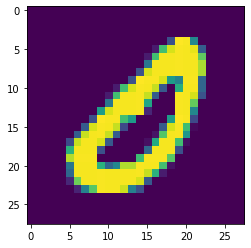

In [18]:
images, labels = next(iter(trainloader))
images = images.to(device)                        # Taking the entire batch to the available device

single_img = images[0]
single_img_permuted = single_img.permute(1, 2, 0) 
single_img_numpy = single_img_permuted.cpu().detach().numpy()

plt.imshow(single_img_numpy)

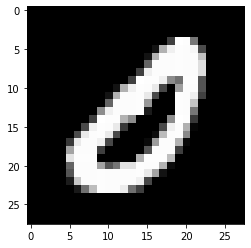

In [19]:
plt.imshow(single_img_numpy, cmap='gray', vmin=0, vmax=1.0)

Let's see the characteristics of an image of the train dataset. The original image of the MNIST dataset, wihtout performing on it, any transofrmation, only the tensor transofrmation, has the following characteristics:

In [20]:
print(single_img.shape)
print(single_img)

torch.Size([1, 28, 28])
tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000,

Analyzing the test dataloader:

In [21]:
for (x, label) in tqdm(testloader):
    images, labels = next(iter(testloader))
    print("the length of this batch is: ", len(images))


  0%|          | 0/167 [00:00<?, ?it/s]

the length of this batch is:  60


  4%|▎         | 6/167 [00:00<00:03, 47.15it/s]

the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is: 

 11%|█▏        | 19/167 [00:00<00:02, 54.74it/s]

 60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60


 19%|█▊        | 31/167 [00:00<00:02, 50.19it/s]

the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is: 

 22%|██▏       | 37/167 [00:00<00:02, 46.85it/s]

 60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is: 

 29%|██▉       | 49/167 [00:00<00:02, 51.35it/s]

 60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is: 

 33%|███▎      | 55/167 [00:01<00:02, 49.66it/s]

 60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is: 

 41%|████      | 68/167 [00:01<00:01, 52.17it/s]

 60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is: 

 44%|████▍     | 74/167 [00:01<00:01, 51.05it/s]

 60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is: 

 51%|█████▏    | 86/167 [00:01<00:01, 51.01it/s]

 60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is: 

 59%|█████▊    | 98/167 [00:01<00:01, 53.14it/s]

 60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is: 

 66%|██████▋   | 111/167 [00:02<00:01, 53.33it/s]

 60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is: 

 71%|███████   | 118/167 [00:02<00:00, 55.32it/s]

 60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is: 

 78%|███████▊  | 130/167 [00:02<00:00, 49.40it/s]

 60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is: 

 81%|████████▏ | 136/167 [00:02<00:00, 51.76it/s]

 60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is: 

 89%|████████▊ | 148/167 [00:02<00:00, 53.47it/s]

 60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is: 

 96%|█████████▌| 160/167 [00:03<00:00, 48.43it/s]

 60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is: 

100%|██████████| 167/167 [00:03<00:00, 51.13it/s]

 60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60


See above that using the command "images, labels = next(iter(testloader))" does not work like with the trainloader; It does not iterate over the testloader variable. See that all batches are of size 60, when we expect for the test loader to have its last batch of a smaller size. However, we do see that the testloader is successfully iterated with:


In [22]:
for (x, label) in tqdm(testloader):
    print("the length of this batch is: ", len(x))

  7%|▋         | 12/167 [00:00<00:01, 114.99it/s]

the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is: 

 21%|██        | 35/167 [00:00<00:01, 97.61it/s] 

 60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is: 

 27%|██▋       | 45/167 [00:00<00:01, 93.89it/s]

 60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is: 

 42%|████▏     | 70/167 [00:00<00:00, 106.37it/s]

 60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is: 

 55%|█████▌    | 92/167 [00:00<00:00, 106.49it/s]

 60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is: 

 62%|██████▏   | 103/167 [00:01<00:00, 102.14it/s]

 60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60


 75%|███████▍  | 125/167 [00:01<00:00, 98.51it/s] 

the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is: 

 88%|████████▊ | 147/167 [00:01<00:00, 102.94it/s]

 60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is: 

100%|██████████| 167/167 [00:01<00:00, 102.59it/s]

 60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  60
the length of this batch is:  40


Now, checking the effect of the transformations: Check the resize transform


In [23]:
nw = 0
transform = transforms.Compose([
        # transforms.RandomCrop(32, padding=4),
        # transforms.RandomHorizontalFlip(),
        transforms.Resize(64),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
        # transforms.Normalize((0.5, 0.5, 0.5),
        #                      (0.5, 0.5, 0.5)),
    ])

mnist = datasets.MNIST('./MINST_original', download=True, train=True, transform = transform)

labels = np.array(mnist.targets)
class_indices = np.argwhere(labels == options_c)
class_indices = class_indices.reshape(class_indices.shape[0])

trainloader = DataLoader(
    mnist, BATCH_SIZE, sampler=sampler.SubsetRandomSampler(class_indices), num_workers=nw, pin_memory=True, drop_last=True) 

test = datasets.MNIST('./MINST_original',train=False, download=False, transform=transform)
testloader = DataLoader(test, BATCH_SIZE*2, num_workers=nw, pin_memory=True)

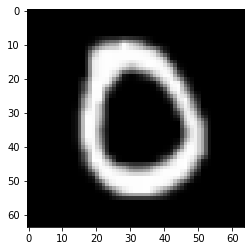

In [24]:
images, labels = next(iter(trainloader))
images = images.to(device)                        # Taking the entire batch to the available device

single_img = images[0]
single_img_permuted = single_img.permute(1, 2, 0) 
single_img_numpy = single_img_permuted.cpu().detach().numpy()

plt.imshow(single_img_numpy)

In [25]:
print("the shape of an image of the dataset is: ", single_img.shape)

the shape of an image of the dataset is:  torch.Size([3, 64, 64])


Checking the effect of the transformations: Check the lambda transform

In [26]:
nw = 0
transform = transforms.Compose([
        # transforms.RandomCrop(32, padding=4),
        # transforms.RandomHorizontalFlip(),
        transforms.Resize(64),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
        # transforms.Normalize((0.5, 0.5, 0.5),
        #                      (0.5, 0.5, 0.5)),
    ])

mnist = datasets.MNIST('./MINST_original', download=True, train=True, transform = transform)

labels = np.array(mnist.targets)
class_indices = np.argwhere(labels == options_c)
class_indices = class_indices.reshape(class_indices.shape[0])

trainloader = DataLoader(
    mnist, BATCH_SIZE, sampler=sampler.SubsetRandomSampler(class_indices), num_workers=nw, pin_memory=True, drop_last=True) 

test = datasets.MNIST('./MINST_original',train=False, download=False, transform=transform)
testloader = DataLoader(test, BATCH_SIZE*2, num_workers=nw, pin_memory=True)

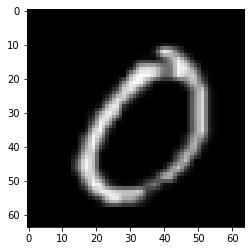

In [27]:
images, labels = next(iter(trainloader))
images = images.to(device)                        # Taking the entire batch to the available device

single_img = images[0]
single_img_permuted = single_img.permute(1, 2, 0) 
single_img_numpy = single_img_permuted.cpu().detach().numpy()

plt.imshow(single_img_numpy)

In [28]:
print(torch.min(images), torch.max(images))

tensor(0., device='cuda:0') tensor(1., device='cuda:0')


In [29]:
print("the shape of an image of the dataset is: ", single_img.shape)

the shape of an image of the dataset is:  torch.Size([3, 64, 64])


See above, that the number of layers is incresased.

Checking the effect of the transformations: Check the normalize transform

In [30]:
nw = 0
transform = transforms.Compose([
        # transforms.RandomCrop(32, padding=4),
        # transforms.RandomHorizontalFlip(),
        transforms.Resize(64),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
        transforms.Normalize((0.5, 0.5, 0.5),
                             (0.5, 0.5, 0.5)),
    ])

mnist = datasets.MNIST('./MINST_original', download=True, train=True, transform = transform)

labels = np.array(mnist.targets)
class_indices = np.argwhere(labels == options_c)
class_indices = class_indices.reshape(class_indices.shape[0])

trainloader = DataLoader(
    mnist, BATCH_SIZE, sampler=sampler.SubsetRandomSampler(class_indices), num_workers=nw, pin_memory=True, drop_last=True) 

test = datasets.MNIST('./MINST_original',train=False, download=False, transform=transform)
testloader = DataLoader(test, BATCH_SIZE*2, num_workers=nw, pin_memory=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


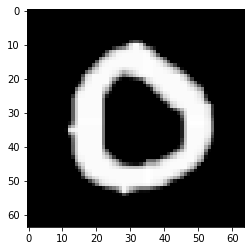

In [31]:
images, labels = next(iter(trainloader))
images = images.to(device)                        # Taking the entire batch to the available device

single_img = images[0]
single_img_permuted = single_img.permute(1, 2, 0) 
single_img_numpy = single_img_permuted.cpu().detach().numpy()

plt.imshow(single_img_numpy)

In [32]:
print("the shape of an image of the dataset is: ", single_img.shape)

the shape of an image of the dataset is:  torch.Size([3, 64, 64])


In [33]:
print(torch.min(images), torch.max(images))

tensor(-1., device='cuda:0') tensor(1., device='cuda:0')


See that the range of the values that the pixels can take is what changes when applying the normalization transformation. Here, the pixel values go from -1 to 1.

# Applying the same tranfsormations to own data

In [34]:
nw = 0

data_dir = '../../Images/BottleStoodUp_atNight/Positive'      #This is for the home laptop

transform = transforms.Compose([
        # transforms.RandomCrop(32, padding=4),
        # transforms.RandomHorizontalFlip(),
        # transforms.Resize(64),
        transforms.ToTensor(),
        # transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
        # transforms.Normalize((0.5, 0.5, 0.5),
        #                      (0.5, 0.5, 0.5)),
    ])

dataset = datasets.ImageFolder(data_dir, transform = transform)

trainloader = DataLoader(
    dataset, BATCH_SIZE, num_workers=nw, pin_memory=True, drop_last=True) 

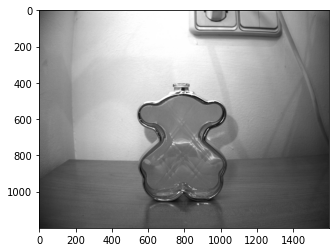

In [35]:
images, labels = next(iter(trainloader))
images = images.to(device)                        # Taking the entire batch to the available device

single_img = images[0]
single_img_permuted = single_img.permute(1, 2, 0) 
single_img_numpy = single_img_permuted.cpu().detach().numpy()

plt.imshow(single_img_numpy)

In [36]:
print("the shape of an image of the dataset is: ", single_img.shape)

the shape of an image of the dataset is:  torch.Size([3, 1200, 1600])


Resizing

In [37]:
nw = 0

data_dir = '../../Images/BottleStoodUp_atNight/Positive'      #This is for the home laptop

transform = transforms.Compose([
        # transforms.RandomCrop(32, padding=4),
        # transforms.RandomHorizontalFlip(),
        transforms.Resize(64),
        transforms.ToTensor(),
        # transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
        # transforms.Normalize((0.5, 0.5, 0.5),
        #                      (0.5, 0.5, 0.5)),
    ])

dataset = datasets.ImageFolder(data_dir, transform = transform)

trainloader = DataLoader(
    dataset, BATCH_SIZE, num_workers=nw, pin_memory=True, drop_last=True) 

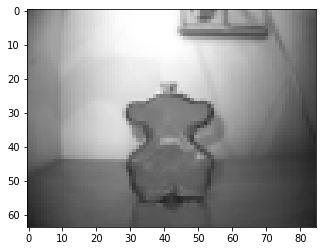

In [38]:
images, labels = next(iter(trainloader))
images = images.to(device)                        # Taking the entire batch to the available device

single_img = images[0]
single_img_permuted = single_img.permute(1, 2, 0) 
single_img_numpy = single_img_permuted.cpu().detach().numpy()

plt.imshow(single_img_numpy)

In [39]:
print("the shape of an image of the dataset is: ", single_img.shape)

the shape of an image of the dataset is:  torch.Size([3, 64, 85])


Applying normalization. We will skip the channels repetition since these images are already 3-channels images

In [40]:
nw = 0

data_dir = '../../Images/BottleStoodUp_atNight/Positive'      #This is for the home laptop

transform = transforms.Compose([
        # transforms.RandomCrop(32, padding=4),
        # transforms.RandomHorizontalFlip(),
        transforms.Resize(64),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5),
                             (0.5, 0.5, 0.5)),
    ])

dataset = datasets.ImageFolder(data_dir, transform = transform)

trainloader = DataLoader(
    dataset, BATCH_SIZE, num_workers=nw, pin_memory=True, drop_last=True) 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


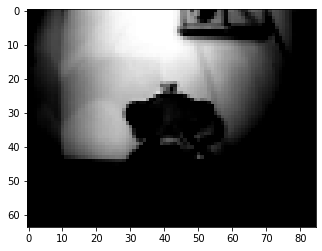

In [41]:
images, labels = next(iter(trainloader))
images = images.to(device)                        # Taking the entire batch to the available device

single_img = images[0]
single_img_permuted = single_img.permute(1, 2, 0) 
single_img_numpy = single_img_permuted.cpu().detach().numpy()

plt.imshow(single_img_numpy)

In [42]:
print(torch.min(images), torch.max(images))

tensor(-0.8118, device='cuda:0') tensor(1., device='cuda:0')


The image does not seem to be good. It is beleived that the normalization of (0.5,0.5) was selected for the MNIST data because it was required to have a strong contrast between black and white colors. And since the entire background is black, it is enough for it that the digit is in white. Not sure if this same normalization process is convenient for our bottles dataset.

## Trying different transformations for bottles dataset

In [53]:
nw = 0

data_dir = '../../Images/BottleStoodUp_atNight/Positive'      #This is for the home laptop

transform = transforms.Compose([
        # transforms.RandomCrop(32, padding=4),
        # transforms.RandomHorizontalFlip(),
        transforms.Resize(255),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        # transforms.Normalize((0.5, 0.5, 0.5),
        #                      (0.5, 0.5, 0.5)),
    ])

dataset = datasets.ImageFolder(data_dir, transform = transform)

trainloader = DataLoader(
    dataset, BATCH_SIZE, num_workers=nw, pin_memory=True, drop_last=False) 

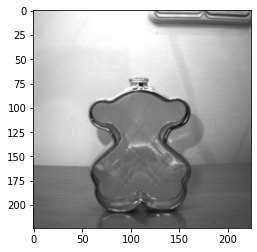

In [54]:
images, labels = next(iter(trainloader))
images = images.to(device)                        # Taking the entire batch to the available device

single_img = images[0]
single_img_permuted = single_img.permute(1, 2, 0) 
single_img_numpy = single_img_permuted.cpu().detach().numpy()

plt.imshow(single_img_numpy)

In [55]:
print("the shape of an image of the dataset is: ", single_img.shape)

the shape of an image of the dataset is:  torch.Size([3, 224, 224])


From the image above, it will be modified and try to crop that a little bit from the top of it.

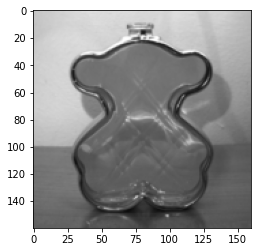

In [56]:
# imgs_croped = transforms.functional.crop(images, 60, 45, 160, 130)
imgs_croped = transforms.functional.crop(images, 60, 30, 160, 160)
# imgs_croped = transforms.functional.crop(images, 60, 30, 164, 164)
single_img = imgs_croped[2]
single_img_permuted = single_img.permute(1, 2, 0) 
single_img_numpy = single_img_permuted.cpu().detach().numpy()

plt.imshow(single_img_numpy)


In [57]:
print("the shape of an image of the dataset is: ", single_img.shape)

the shape of an image of the dataset is:  torch.Size([3, 160, 160])


From above it can be concluded that:
- Load the images with the resize and crop transformations
- Perform another crop of the images but batch by batch using the "transforms.functional.crop()" function
- The shape of an image is: [3, 160, 160]

## Checking the length of dataloaders

In [58]:
print(len(trainloader))
images, labels = next(iter(trainloader))
print(images.shape)

6
torch.Size([30, 3, 224, 224])


In [59]:
# crit = nn.MSELoss()
y_true, y_score = [], []
in_real, out_real, in_rec, out_rec = [], [], [], []
with torch.no_grad():
    for (x, label) in tqdm(trainloader):                     # Iterate over the batches in the test set (dataloader). "x" refers to the batch of 60 images and "label" stands for the batch of labels, which take numbers from 0 to 9
        print("this is x: ", len(label))
        print("This is the first element of the label variable", label[0])
        

 17%|█▋        | 1/6 [00:00<00:02,  1.88it/s]

this is x:  30
This is the first element of the label variable tensor(0)


 33%|███▎      | 2/6 [00:01<00:02,  1.89it/s]

this is x:  30
This is the first element of the label variable tensor(0)


 50%|█████     | 3/6 [00:01<00:01,  1.85it/s]

this is x:  30
This is the first element of the label variable tensor(0)


 67%|██████▋   | 4/6 [00:02<00:01,  1.89it/s]

this is x:  30
This is the first element of the label variable tensor(0)


 83%|████████▎ | 5/6 [00:02<00:00,  1.85it/s]

this is x:  30
This is the first element of the label variable tensor(0)


100%|██████████| 6/6 [00:03<00:00,  1.78it/s]

this is x:  29
This is the first element of the label variable tensor(0)


Now, perform the same transformations for the test set

In [64]:
nw = 0

test_dir = '../../Images/BottleStoodUp_atNight/Evaluation'      #This is for the home laptop

transform = transforms.Compose([
        # transforms.RandomCrop(32, padding=4),
        # transforms.RandomHorizontalFlip(),
        transforms.Resize(255),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        # transforms.Normalize((0.5, 0.5, 0.5),
        #                      (0.5, 0.5, 0.5)),
    ])

dataset_test = datasets.ImageFolder(test_dir, transform = transform)

dataloader_test = DataLoader(
    dataset_test, BATCH_SIZE, num_workers=nw, pin_memory=True, drop_last=False) 

In [65]:
print(len(dataloader_test))

1


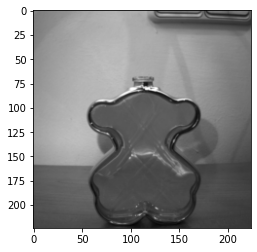

In [62]:
images, labels = next(iter(dataloader_test))
images = images.to(device)                        # Taking the entire batch to the available device

single_img = images[0]
single_img_permuted = single_img.permute(1, 2, 0) 
single_img_numpy = single_img_permuted.cpu().detach().numpy()

plt.imshow(single_img_numpy)

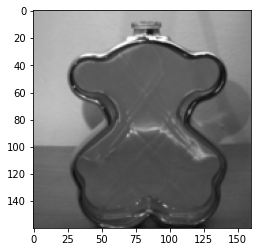

In [63]:
# imgs_croped = transforms.functional.crop(images, 60, 45, 160, 130)
imgs_croped = transforms.functional.crop(images, 60, 30, 160, 160)
# imgs_croped = transforms.functional.crop(images, 60, 30, 164, 164)
single_img = imgs_croped[2]
single_img_permuted = single_img.permute(1, 2, 0) 
single_img_numpy = single_img_permuted.cpu().detach().numpy()

plt.imshow(single_img_numpy)